In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

In [2]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from skimage import measure
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class,generate_data
from GRF_perturbations.Modules.Image_processing import scipy_fit_image,compute_radial_spectrum,Radial_profile,differentiable_fit_image
from GRF_perturbations.Modules.Jax_Utils import purify_function,jax_map
from GRF_perturbations.Modules.Inference import distribution_Noise_LogSpectrum,compute_SNR_grid,Inference_pipeline,plot_likelihood,infer_LogNorm_params,compute_Loss_grid,Spectra_Loss,compute_Confidence_grid


#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


ImportError: cannot import name 'get_jaxified_GRF_true_var' from 'GRF_perturbations.Modules.GRF_generation' (/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/GRF_generation.py)

In [3]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)

get_GRF=Observation_conditions.GRF_getter
simulate_perturbed_image=Observation_conditions.perturbed_image_getter
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
simulate_unperturbed_image_pure=lambda kwargs: simulate_unperturbed_image(kwargs,Noise_flag=False)
simulate_perturbed_image_pure=lambda GRF_potential,noise_seed: simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Observation_conditions.annulus_mask,Observation_conditions.init_freq_index)


noise_var=Observation_conditions.noise_var
parameters=Observation_conditions.parameters
Estimated_Noise_spectral_density=(noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()

get_GRF=Observation_conditions.GRF_getter()
get_GRF_True_var=Observation_conditions.GRF_getter(True)
differentiable_fit_image_pure= purify_function(differentiable_fit_image,simulate_unperturbed_image_pure,parameters.kwargs2args(Observation_conditions.kwargs_data),noise_var,parameters,400,1e-4)
extent = Observation_conditions.pixel_grid.extent
frequencies=Observation_conditions.frequencies

NameError: name 'Observation_conditions_class' is not defined

In [4]:
Observation_conditions.pixel_scale

100

In [10]:
logvar=-1
slope=-2


In [12]:
var_dpsi = np.power(10.,logvar)    # variance
pow_dpsi = slope                  # power-law exponent
Lx_dpsi  = pixel_number*pixel_scale                  # field of view (in arc-sec)
Ly_dpsi  = pixel_number*pixel_scale                # field of view (in arc-sec)
nx_dpsi  = pixel_number                   # number of pixels
nx_dpsi  = pixel_number                  # number of pixels

In [13]:
L_dpsi = Lx_dpsi
n_dpsi = nx_dpsi

nx = n_dpsi
ny = n_dpsi
Lx = L_dpsi
Ly = L_dpsi

In [14]:
resolution = float(Lx)/float(nx)
X = np.linspace(-Lx/2.0,Lx/2.0,nx)
Y = np.linspace(-Ly/2.0,Ly/2.0,ny)
x,y = np.meshgrid(X,Y,sparse='True')

grpar      = np.asarray([nx,ny,Lx,Ly,var_dpsi,pow_dpsi])
gauss_rand = grf.gauss_rand_2d(grpar)

In [26]:
betas=np.linspace(0.1,5,20)
variances=np.zeros((100,100))

for i,beta in tqdm(enumerate(betas)):
    grpar      = np.asarray([nx,ny,Lx,Ly,var_dpsi,beta])
    for j in range(100):
        np.random.seed(j+1)
        variances[i,j]=grf.gauss_rand_2d(grpar).var()

20it [01:27,  4.37s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

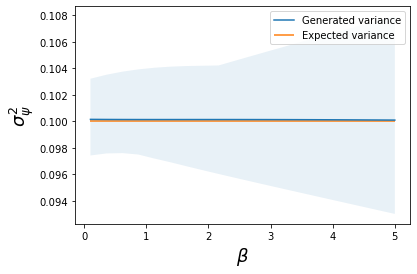

In [44]:
plt.hlines(var_dpsi,betas[0],betas[-1],label='Expected variance',color='C1')
plt.plot(betas,variances.mean(axis=1),label='Generated variance',color='C0')
plt.fill_between(betas,variances.min(axis=1),variances.max(axis=1),alpha=0.1)
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$\sigma^2_{\psi}$',fontsize=FS)

plt.legend()
plt.show

In [37]:
from GRF_perturbations.Modules.GRF_generation import *
kgrid,dx=get_k_grid_dx(Observation_conditions.pixel_number,Observation_conditions.pixel_scale)
freqs=np.fft.fftshift(np.fft.fftfreq(Observation_conditions.pixel_number,Observation_conditions.pixel_scale))[Observation_conditions.pixel_number//2:]
def power_spectrum(GRF_params,kgrid):
    return np.where(kgrid!=0,np.power(10.,GRF_params[0])*np.power(kgrid,-GRF_params[1]),0)

In [40]:
betas=np.linspace(0.1,5,20)
variances_pbox=np.zeros((20,100))

for i,beta in tqdm(enumerate(betas)):
    total_power=power_spectrum([-7,beta],kgrid).sum()
    for j in range(100):
        A=(1e-7)/total_power/10
        variances_pbox[i,j]=get_GRF([np.log10(A),beta],j).std()**2

0it [00:00, ?it/s]/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_4251/1518524084.py:5: RuntimeWarning: divide by zero encountered in power
  return np.where(kgrid!=0,np.power(10.,GRF_params[0])*np.power(kgrid,-GRF_params[1]),0)
20it [00:06,  2.97it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

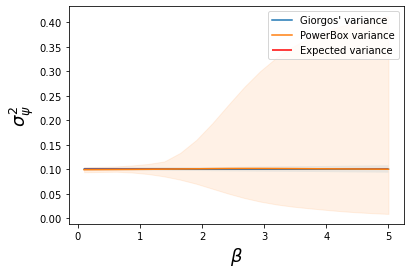

In [51]:
plt.hlines(0.1,betas[0],betas[-1],label='Expected variance',color='red')
plt.plot(betas,variances.mean(axis=1),label="Giorgos' variance",color='C0')
plt.fill_between(betas,variances.min(axis=1),variances.max(axis=1),alpha=0.1)


plt.plot(betas,variances_pbox.mean(axis=1),label="PowerBox variance",color='C1')
plt.fill_between(betas,variances_pbox.min(axis=1),variances_pbox.max(axis=1),alpha=0.1,color='C1')

plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$\sigma^2_{\psi}$',fontsize=FS)

plt.legend()
plt.show

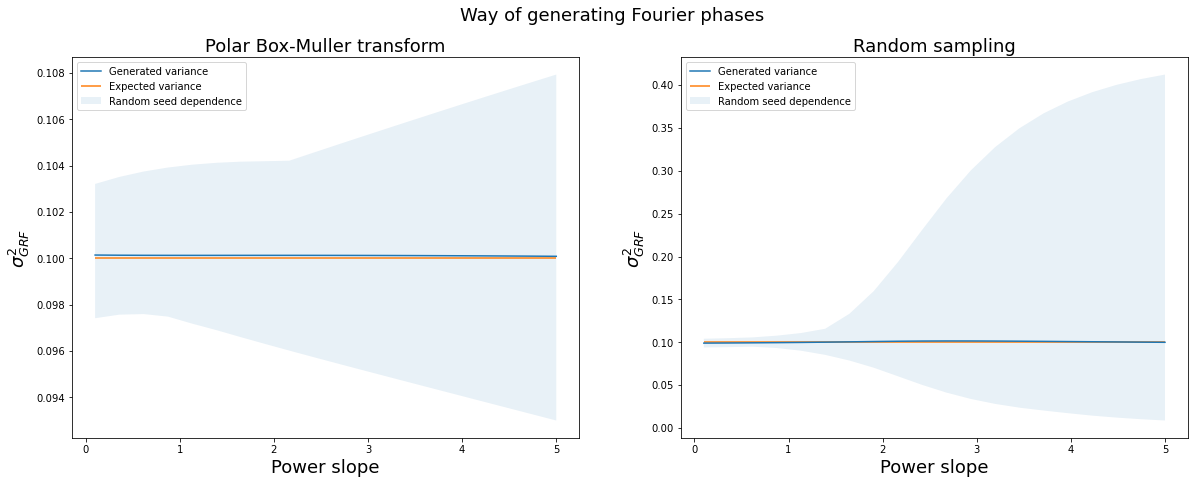

In [60]:
fig,ax=plt.subplots(1,2,figsize=(20,7))


ax[0].plot(betas,variances.mean(axis=1),label="Generated variance",color='C0')
ax[0].hlines(0.1,betas[0],betas[-1],label='Expected variance',color='C1')
ax[0].fill_between(betas,variances.min(axis=1),variances.max(axis=1),alpha=0.1,label='Random seed dependence')
ax[0].set_title('Polar Box-Muller transform',fontsize=FS)


ax[1].plot(betas,variances_pbox.mean(axis=1),label="Generated variance",color='C0')
ax[1].hlines(0.1,betas[0],betas[-1],label='Expected variance',color='C1')
ax[1].fill_between(betas,variances_pbox.min(axis=1),variances_pbox.max(axis=1),alpha=0.1,label='Random seed dependence')
ax[1].set_title('Random sampling',fontsize=FS)

fig.suptitle('Way of generating Fourier phases',fontsize=FS)

for i in range(2):
    ax[i].set_xlabel('Power slope',fontsize=FS)
    ax[i].set_ylabel(r'$\sigma^2_{GRF}$',fontsize=FS)
    ax[i].legend(loc='upper left')

# Polar Box-Muller transform

In [63]:
power_spectrum??

In [94]:
GRF_params=[-7,2]

sq_PS=np.sqrt(power_spectrum(GRF_params,kgrid))
s = 1.1
while s > 1. :
    u = np.random.uniform (-1.,1.) 
    v = np.random.uniform (-1.,1.)
    s = u**2. + v**2.
fac = math.sqrt(-2.*math.log(s)/s)
z1 = u*fac*np.ones((pixel_number,pixel_number))
z2 = v*fac*np.ones((pixel_number,pixel_number))

Fourier_phase=z1+z2*(0+1j)'''
Fourier_phase[0,pixel_number//2]=z1[0]
Fourier_phase[pixel_number//2,0]=z1
Fourier_phase[pixel_number//2,pixel_number//2]=z1

Fourier_phase[::-1,::-1]=Fourier_phase[::-1,::-1].conjugate()'''

SyntaxError: invalid syntax (1052096797.py, line 18)

In [98]:
u = np.random.uniform (-1.,1.,size=(100,100)) 
v = np.random.uniform (-1.,1.,size=(100,100))

In [100]:
s = u**2. + v**2.

In [106]:
np.random.seed(1)

In [109]:
np.random.uniform (-1.,1.)

-0.9997712503653102

In [96]:
z1

array([[-0.20411527, -0.20411527, -0.20411527, ..., -0.20411527,
        -0.20411527, -0.20411527],
       [-0.20411527, -0.20411527, -0.20411527, ..., -0.20411527,
        -0.20411527, -0.20411527],
       [-0.20411527, -0.20411527, -0.20411527, ..., -0.20411527,
        -0.20411527, -0.20411527],
       ...,
       [-0.20411527, -0.20411527, -0.20411527, ..., -0.20411527,
        -0.20411527, -0.20411527],
       [-0.20411527, -0.20411527, -0.20411527, ..., -0.20411527,
        -0.20411527, -0.20411527],
       [-0.20411527, -0.20411527, -0.20411527, ..., -0.20411527,
        -0.20411527, -0.20411527]])

In [79]:
Fourier_image[49,50]

(0.0011884858777563823+0.0022493799429354764j)

In [95]:
Fourier_phase

array([[-0.20411527+0.36123078j, -0.20411527+0.36123078j,
        -0.20411527+0.36123078j, ..., -0.20411527+0.36123078j,
        -0.20411527+0.36123078j, -0.20411527+0.36123078j],
       [-0.20411527+0.36123078j, -0.20411527+0.36123078j,
        -0.20411527+0.36123078j, ..., -0.20411527+0.36123078j,
        -0.20411527+0.36123078j, -0.20411527+0.36123078j],
       [-0.20411527+0.36123078j, -0.20411527+0.36123078j,
        -0.20411527+0.36123078j, ..., -0.20411527+0.36123078j,
        -0.20411527+0.36123078j, -0.20411527+0.36123078j],
       ...,
       [-0.20411527+0.36123078j, -0.20411527+0.36123078j,
        -0.20411527+0.36123078j, ..., -0.20411527+0.36123078j,
        -0.20411527+0.36123078j, -0.20411527+0.36123078j],
       [-0.20411527+0.36123078j, -0.20411527+0.36123078j,
        -0.20411527+0.36123078j, ..., -0.20411527+0.36123078j,
        -0.20411527+0.36123078j, -0.20411527+0.36123078j],
       [-0.20411527+0.36123078j, -0.20411527+0.36123078j,
        -0.20411527+0.36123078

In [87]:
Fourier_phase[(0,3),(5,2)]=1

In [89]:
Fourier_phase[[0,1],[1,2]]

array([-0.20411527+0.36123078j, -0.20411527+0.36123078j])

In [93]:
Fourier_phase[1,5]

(-0.20411527454102785+0.36123078471608927j)

In [ ]:
def Fourier_image_correction(Fourier_image,npix):
    
    

In [120]:
arr=np.load('../Precomputed_data/Box_Muller_cosine_sine.npz')

In [121]:
BM_cosine=arr['cosine']
BM_sine=arr['sine']



In [122]:
BM_cosine.shape

(100, 100, 100)

In [123]:
BM_sine.shape

(100, 100, 100)

In [124]:
s=BM_cosine**2+BM_sine**2

In [127]:
(s<=1).all()

True

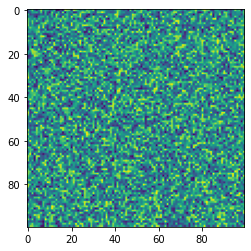

In [133]:
plt.imshow(BM_cosine[4])

In [135]:
q=np.fft.fftfreq(100,0.08)

In [ ]:
k_grid=np.m

In [136]:
q

array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
        1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,
        2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,  2.875,
        3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,  3.75 ,  3.875,
        4.   ,  4.125,  4.25 ,  4.375,  4.5  ,  4.625,  4.75 ,  4.875,
        5.   ,  5.125,  5.25 ,  5.375,  5.5  ,  5.625,  5.75 ,  5.875,
        6.   ,  6.125, -6.25 , -6.125, -6.   , -5.875, -5.75 , -5.625,
       -5.5  , -5.375, -5.25 , -5.125, -5.   , -4.875, -4.75 , -4.625,
       -4.5  , -4.375, -4.25 , -4.125, -4.   , -3.875, -3.75 , -3.625,
       -3.5  , -3.375, -3.25 , -3.125, -3.   , -2.875, -2.75 , -2.625,
       -2.5  , -2.375, -2.25 , -2.125, -2.   , -1.875, -1.75 , -1.625,
       -1.5  , -1.375, -1.25 , -1.125, -1.   , -0.875, -0.75 , -0.625,
       -0.5  , -0.375, -0.25 , -0.125])

In [138]:
    resolution = float(Lx) / float(nx)
    lxaxis = np.fft.fftfreq (nx, resolution)
    lyaxis = np.fft.fftfreq (ny, resolution)

    lx = list (np.zeros([nx, 1]))
    ly = list (np.zeros([ny, 1]))

    for x in range (len(lx)):
        lx [x] = lxaxis
    
    for y in range (len(ly)):
        ly [y] = lyaxis
    
    lx = np.array (lx)
    ly = np.transpose(np.array (ly))
    l  = np.sqrt (lx**2. + ly**2.)
    
    summ = 0.
    for y in range(np.shape(l)[0]):
        for x in range(np.shape(l)[1]):
            if l[y][x]==0.:
                summ += 0.
            else:
                summ += l[y][x]**(-2)

In [139]:
resolution

0.08

In [140]:
lxaxis

array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
        1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,
        2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,  2.875,
        3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,  3.75 ,  3.875,
        4.   ,  4.125,  4.25 ,  4.375,  4.5  ,  4.625,  4.75 ,  4.875,
        5.   ,  5.125,  5.25 ,  5.375,  5.5  ,  5.625,  5.75 ,  5.875,
        6.   ,  6.125, -6.25 , -6.125, -6.   , -5.875, -5.75 , -5.625,
       -5.5  , -5.375, -5.25 , -5.125, -5.   , -4.875, -4.75 , -4.625,
       -4.5  , -4.375, -4.25 , -4.125, -4.   , -3.875, -3.75 , -3.625,
       -3.5  , -3.375, -3.25 , -3.125, -3.   , -2.875, -2.75 , -2.625,
       -2.5  , -2.375, -2.25 , -2.125, -2.   , -1.875, -1.75 , -1.625,
       -1.5  , -1.375, -1.25 , -1.125, -1.   , -0.875, -0.75 , -0.625,
       -0.5  , -0.375, -0.25 , -0.125])

In [145]:
lx

array([[ 0.   ,  0.125,  0.25 , ..., -0.375, -0.25 , -0.125],
       [ 0.   ,  0.125,  0.25 , ..., -0.375, -0.25 , -0.125],
       [ 0.   ,  0.125,  0.25 , ..., -0.375, -0.25 , -0.125],
       ...,
       [ 0.   ,  0.125,  0.25 , ..., -0.375, -0.25 , -0.125],
       [ 0.   ,  0.125,  0.25 , ..., -0.375, -0.25 , -0.125],
       [ 0.   ,  0.125,  0.25 , ..., -0.375, -0.25 , -0.125]])

In [143]:
k_vector=np.fft.fftfreq(pixel_number,pixel_scale)
kx,ky=np.meshgrid(k_vector,k_vector)

In [144]:
kx

array([[ 0.   ,  0.125,  0.25 , ..., -0.375, -0.25 , -0.125],
       [ 0.   ,  0.125,  0.25 , ..., -0.375, -0.25 , -0.125],
       [ 0.   ,  0.125,  0.25 , ..., -0.375, -0.25 , -0.125],
       ...,
       [ 0.   ,  0.125,  0.25 , ..., -0.375, -0.25 , -0.125],
       [ 0.   ,  0.125,  0.25 , ..., -0.375, -0.25 , -0.125],
       [ 0.   ,  0.125,  0.25 , ..., -0.375, -0.25 , -0.125]])

In [146]:
l

array([[0.        , 0.125     , 0.25      , ..., 0.375     , 0.25      ,
        0.125     ],
       [0.125     , 0.1767767 , 0.2795085 , ..., 0.39528471, 0.2795085 ,
        0.1767767 ],
       [0.25      , 0.2795085 , 0.35355339, ..., 0.45069391, 0.35355339,
        0.2795085 ],
       ...,
       [0.375     , 0.39528471, 0.45069391, ..., 0.53033009, 0.45069391,
        0.39528471],
       [0.25      , 0.2795085 , 0.35355339, ..., 0.45069391, 0.35355339,
        0.2795085 ],
       [0.125     , 0.1767767 , 0.2795085 , ..., 0.39528471, 0.2795085 ,
        0.1767767 ]])

In [149]:
k_grid=np.sqrt(kx**2+ky**2)

In [150]:
k_grid

array([[0.        , 0.125     , 0.25      , ..., 0.375     , 0.25      ,
        0.125     ],
       [0.125     , 0.1767767 , 0.2795085 , ..., 0.39528471, 0.2795085 ,
        0.1767767 ],
       [0.25      , 0.2795085 , 0.35355339, ..., 0.45069391, 0.35355339,
        0.2795085 ],
       ...,
       [0.375     , 0.39528471, 0.45069391, ..., 0.53033009, 0.45069391,
        0.39528471],
       [0.25      , 0.2795085 , 0.35355339, ..., 0.45069391, 0.35355339,
        0.2795085 ],
       [0.125     , 0.1767767 , 0.2795085 , ..., 0.39528471, 0.2795085 ,
        0.1767767 ]])

In [160]:
k_vector

array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
        1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,
        2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,  2.875,
        3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,  3.75 ,  3.875,
        4.   ,  4.125,  4.25 ,  4.375,  4.5  ,  4.625,  4.75 ,  4.875,
        5.   ,  5.125,  5.25 ,  5.375,  5.5  ,  5.625,  5.75 ,  5.875,
        6.   ,  6.125, -6.25 , -6.125, -6.   , -5.875, -5.75 , -5.625,
       -5.5  , -5.375, -5.25 , -5.125, -5.   , -4.875, -4.75 , -4.625,
       -4.5  , -4.375, -4.25 , -4.125, -4.   , -3.875, -3.75 , -3.625,
       -3.5  , -3.375, -3.25 , -3.125, -3.   , -2.875, -2.75 , -2.625,
       -2.5  , -2.375, -2.25 , -2.125, -2.   , -1.875, -1.75 , -1.625,
       -1.5  , -1.375, -1.25 , -1.125, -1.   , -0.875, -0.75 , -0.625,
       -0.5  , -0.375, -0.25 , -0.125])

In [161]:
kx=np.roll(k_vector,50)

In [162]:
kx

array([-6.25 , -6.125, -6.   , -5.875, -5.75 , -5.625, -5.5  , -5.375,
       -5.25 , -5.125, -5.   , -4.875, -4.75 , -4.625, -4.5  , -4.375,
       -4.25 , -4.125, -4.   , -3.875, -3.75 , -3.625, -3.5  , -3.375,
       -3.25 , -3.125, -3.   , -2.875, -2.75 , -2.625, -2.5  , -2.375,
       -2.25 , -2.125, -2.   , -1.875, -1.75 , -1.625, -1.5  , -1.375,
       -1.25 , -1.125, -1.   , -0.875, -0.75 , -0.625, -0.5  , -0.375,
       -0.25 , -0.125,  0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,
        0.75 ,  0.875,  1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,
        1.75 ,  1.875,  2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,
        2.75 ,  2.875,  3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,
        3.75 ,  3.875,  4.   ,  4.125,  4.25 ,  4.375,  4.5  ,  4.625,
        4.75 ,  4.875,  5.   ,  5.125,  5.25 ,  5.375,  5.5  ,  5.625,
        5.75 ,  5.875,  6.   ,  6.125])

In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from skimage import measure
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
npix=100
pix_scl=0.08
k_vector=np.fft.fftfreq(npix,pix_scl)
kx,ky=np.meshgrid(k_vector,k_vector)
k_grid=np.sqrt(kx**2+ky**2)
nonsingular_k_grid=deepcopy(k_grid)
nonsingular_k_grid[0,0]=1

In [4]:
  npix=100
  pix_scl=0.08
  np.random.seed(1+1)

  #These are U1 and U2 from Box-Muller polar transform (wiki)
  cosine_grid=np.zeros((npix//2+2,npix))
  sine_grid=np.zeros((npix//2+2,npix))

  for y in range(npix//2+2):
    for x in range(npix):
      s = 1.1
      while s>1. :
        u = np.random.uniform (-1.,1.)
        v = np.random.uniform (-1.,1.)
        s=u**2.+v**2.
      cosine_grid[y,x]=u
      sine_grid[y,x]=v

In [8]:
s=cosine_grid**2+sine_grid**2
factor=np.sqrt(-2*np.log(s)/s)

z0=cosine_grid*factor
z1=sine_grid*factor

In [9]:
Fourier_phase_grid=np.zeros((npix,npix),dtype=complex)
Fourier_phase_grid[:npix//2+2,:]=z0+z1*(0+1j)

#Mean value of GRF is zero
Fourier_phase_grid[0,0]=0

# three points that need to be real valued to get a real image after FFT:
Fourier_phase_grid[npix//2,0]=z0[npix//2,0]
Fourier_phase_grid[0,npix//2]=z0[0,npix//2]
Fourier_phase_grid[npix//2,npix//2]=z0[npix//2,npix//2]

In [10]:
for y in range(npix//2+2):
    #print(y)
    for x in range(npix):
        #print(y,x)
        Fourier_phase_grid[-y][-x]=Fourier_phase_grid[y][x].conjugate()

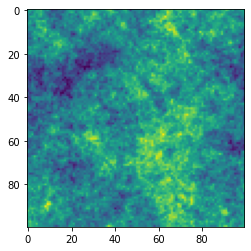

In [11]:
Fourier_image=Fourier_phase_grid*jnp.sqrt(PS)
GRF=np.fft.ifftshift(np.fft.ifft2(Fourier_image))
plt.imshow(GRF.real)

In [2]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from skimage import measure
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)


#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
npix=100
pix_scl=0.08
k_vector=np.fft.fftfreq(npix,pix_scl)
kx,ky=np.meshgrid(k_vector,k_vector)
k_grid=np.sqrt(kx**2+ky**2)
nonsingular_k_grid=deepcopy(k_grid)
nonsingular_k_grid[0,0]=1

In [4]:
from GRF_perturbations.Modules.GRF_generation import Box_Muller_Fourier_phase_grid,Power_Spectrum,get_jaxified_GRF

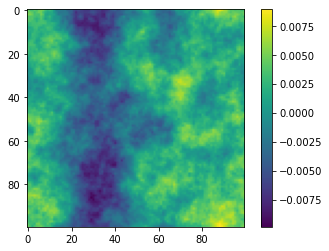

500.1094742691707
1.1793830990664986e-05


In [5]:
seed=7
GRF_params=[1,3]
GRF=get_jaxified_GRF(GRF_params,nonsingular_k_grid,Box_Muller_Fourier_phase_grid(100,seed))
plt.imshow(GRF)
plt.colorbar()
plt.show()

print(Power_Spectrum(GRF_params,nonsingular_k_grid).sum())
print(GRF.var())

In [5]:
betas=np.linspace(0.1,5,20)
variances=np.zeros((20,100))

for i,beta in tqdm(enumerate(betas)):
    for j in range(100):
        variances[i,j]=np.var(get_jaxified_GRF([0.1,beta],nonsingular_k_grid,Box_Muller_Fourier_phase_grid(100,j)))

20it [00:39,  1.98s/it]


In [6]:
variances

array([[9.97034078e-06, 9.98124723e-06, 9.92980555e-06, ...,
        1.00669464e-05, 1.02074062e-05, 1.00849608e-05],
       [1.00070472e-05, 1.00011467e-05, 9.90617981e-06, ...,
        1.00966263e-05, 1.02191638e-05, 1.00668609e-05],
       [1.00647574e-05, 1.00313738e-05, 9.86544692e-06, ...,
        1.01554990e-05, 1.02182351e-05, 1.00388260e-05],
       ...,
       [9.16111407e-06, 1.85255367e-05, 8.05902865e-06, ...,
        1.31140258e-05, 9.63788941e-06, 6.41486745e-06],
       [8.86802027e-06, 1.88621363e-05, 8.09882274e-06, ...,
        1.29736553e-05, 9.79330725e-06, 6.38065305e-06],
       [8.59524455e-06, 1.91590819e-05, 8.14443526e-06, ...,
        1.28358983e-05, 9.94224937e-06, 6.35845157e-06]])

In [11]:
expectred_var=Power_Spectrum(GRF_params,nonsingular_k_grid).sum()/(pix_scl*npix)**2

<function matplotlib.pyplot.show(close=None, block=None)>

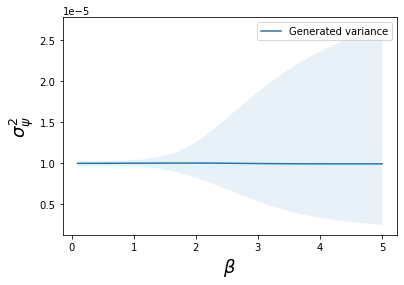

In [7]:
#plt.hlines(expectred_var,betas[0],betas[-1],label='Expected variance',color='C1')
#plt.plot(betas,expected_variances,label='Expected variance',color='C1')
plt.plot(betas,variances.mean(axis=1),label='Generated variance',color='C0')
plt.fill_between(betas,variances.min(axis=1),variances.max(axis=1),alpha=0.1)
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$\sigma^2_{\psi}$',fontsize=FS)

plt.legend()
plt.show

In [41]:
Fourier_phases=Box_Muller_Fourier_phase_grid(100,j)

In [14]:
from GRF_perturbations.Modules.grf_functions import *

In [15]:
Psum=Psum_calculator(npix,npix,pix_scl*npix,pix_scl*npix,-2)

In [29]:
Psum

1782.7785140093654

In [30]:
np.power(nonsingular_k_grid,-2).sum()-1

1782.7785140093545

In [8]:
from GRF_perturbations.Modules.GRF_generation import *

In [9]:
PS=np.vectorize(powspec)(k_grid,0.1,npix**4,Psum,-2)

NameError: name 'powspec' is not defined

In [10]:
PS

NameError: name 'PS' is not defined

In [11]:
GRF=np.fft.ifftshift(np.fft.ifft2(Fourier_phases*np.sqrt(PS))).real

NameError: name 'Fourier_phases' is not defined

In [47]:
GRF.var()

8901547.57325767

In [23]:
def gauss_rand_2d (par):
    nx = par[0].astype(int)
    ny = par[1].astype(int)
    Lx = par[2]
    Ly = par[3]
    var = par[4]
    power = par[5]

    j= 0 + 1j # Defining the complex number
    plane = np.zeros ([nx, ny], dtype='cfloat') # Empty matrix to be filled in for the Fourier plane

    #lxaxis = np.append (np.arange (0.,(nx/2.)/Lx, 1./Lx), np.arange ((-nx/2.)/Lx, 0.,1./Lx))
    #lyaxis = np.append (np.arange (0.,(ny/2.)/Ly, 1./Ly), np.arange ((-ny/2.)/Ly, 0.,1./Ly))

    resolution = float(Lx) / float(nx)
    lxaxis = np.fft.fftfreq (nx, resolution)
    lyaxis = np.fft.fftfreq (ny, resolution)

    Psum = Psum_calculator (nx, ny, Lx, Ly, power)

    for y in range(np.shape(plane)[0]):
        for x in range(np.shape(plane)[1]):
            # The coordinates centered at x = n/2, y = n/2
            i1 = x - nx/2
            j1 = y - ny/2 

            #The coordinates in the Fourier plane
            lx = lxaxis [x]
            ly = lyaxis [y]
            # The magnitude of the l-vector
            l = np.sqrt (lx**2. + ly**2.) 

            # Filling in the grid
            if x==0 and y==0: # average of the field
                plane[y][x] = 0.0
                continue
            
            # Polar Box-Muller transform
            sigma = math.sqrt(powspec(l, var, nx*ny, Psum, power))
            s = 1.1
            while (s >= 1.) or (s==0) :
                u = np.random.uniform (-sigma,sigma) 
                v = np.random.uniform (-sigma,sigma)
                
                nu=u/sigma
                nv=v/sigma
                
                s = nu**2. + nv**2.
            fac = math.sqrt(-2.*math.log(s)/s)
            z1 = u*fac
            z2 = v*fac

            

            # three points that need to be real valued to get a real image after FFT:
            if x== 0 and y==ny/2:
                plane[y][x] = z1
            elif x==nx/2 and y==0:
                plane[y][x] = z1
            elif x==nx/2 and y==ny/2:
                plane[y][x] = z1
            else :
                plane[y][x] = z1+j*z2

            # Creating symmetry f(k) = f*(-k)
            y2 = int( -(j1 + ny/2) )
            x2 = int( -(i1 + nx/2) )
        
            plane[y2][x2] = plane[y][x].conjugate()

        if y>np.shape(plane)[0]/2.:
            break
    return np.fft.ifftshift(np.fft.ifft2(plane)).real

In [24]:
betas=np.linspace(0.1,5,20)
variances=np.zeros((20,20))

for i,beta in tqdm(enumerate(betas)):
    for j in range(20):
        #Fourier_phase_grid=Box_Muller_Fourier_phase_grid(100,j,beta)
        #variances[i,j]=(np.fft.ifftshift(np.fft.ifft2(Fourier_phase_grid)).real).var()
        np.random.seed(j)
        grpar      = np.asarray([100,100,8,8,1,-beta])
        GRF=gauss_rand_2d(grpar)
        
        variances[i,j]=GRF.var()

20it [00:17,  1.14it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

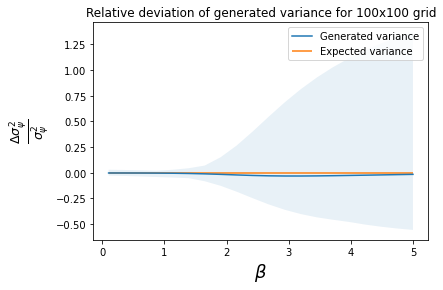

In [25]:
plt.hlines(0,betas[0],betas[-1],label='Expected variance',color='C1')
plt.plot(betas,(variances.mean(axis=1)-1),label='Generated variance',color='C0')
plt.fill_between(betas,(variances.min(axis=1)-1),(variances.max(axis=1)-1),alpha=0.1)
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$\frac{\Delta \sigma^2_{\psi}}{\sigma^2_{\psi}}$',fontsize=FS)

plt.title('Relative deviation of generated variance for 100x100 grid')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

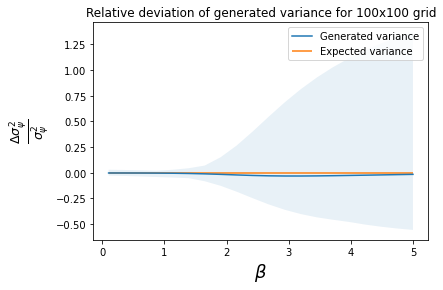

In [22]:
plt.hlines(0,betas[0],betas[-1],label='Expected variance',color='C1')
plt.plot(betas,(variances.mean(axis=1)-1),label='Generated variance',color='C0')
plt.fill_between(betas,(variances.min(axis=1)-1),(variances.max(axis=1)-1),alpha=0.1)
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$\frac{\Delta \sigma^2_{\psi}}{\sigma^2_{\psi}}$',fontsize=FS)

plt.title('Relative deviation of generated variance for 100x100 grid')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

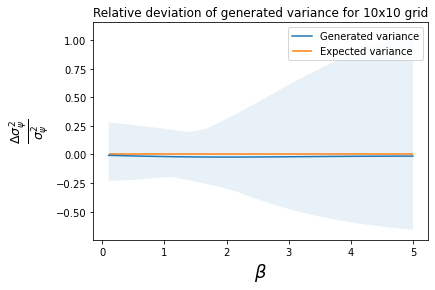

In [230]:
plt.hlines(0,betas[0],betas[-1],label='Expected variance',color='C1')
plt.plot(betas,(variances.mean(axis=1)-1),label='Generated variance',color='C0')
plt.fill_between(betas,(variances.min(axis=1)-1),(variances.max(axis=1)-1),alpha=0.1)
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$\frac{\Delta \sigma^2_{\psi}}{\sigma^2_{\psi}}$',fontsize=FS)

plt.title('Relative deviation of generated variance for 10x10 grid')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

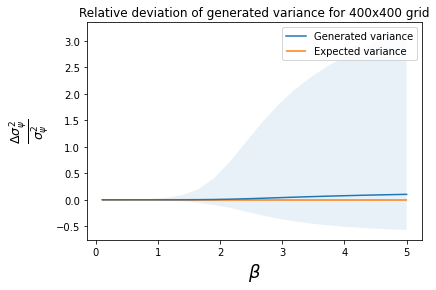

In [212]:
plt.hlines(0,betas[0],betas[-1],label='Expected variance',color='C1')
plt.plot(betas,(variances.mean(axis=1)-1),label='Generated variance',color='C0')
plt.fill_between(betas,(variances.min(axis=1)-1),(variances.max(axis=1)-1),alpha=0.1)
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$\frac{\Delta \sigma^2_{\psi}}{\sigma^2_{\psi}}$',fontsize=FS)

plt.title('Relative deviation of generated variance for 400x400 grid')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

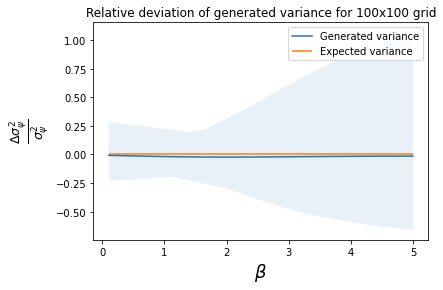

In [208]:
plt.hlines(0,betas[0],betas[-1],label='Expected variance',color='C1')
plt.plot(betas,(variances.mean(axis=1)-1),label='Generated variance',color='C0')
plt.fill_between(betas,(variances.min(axis=1)-1),(variances.max(axis=1)-1),alpha=0.1)
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$\frac{\Delta \sigma^2_{\psi}}{\sigma^2_{\psi}}$',fontsize=FS)

plt.title('Relative deviation of generated variance for 100x100 grid')
plt.legend()
plt.show

In [217]:
np.sqrt(PS.max())

181.01933598375618

In [220]:
PS[0,0]=1

In [221]:
PS.min()

1.8536380004736628e-05

In [222]:
np.sqrt(PS.min())

0.004305389646099018

<function matplotlib.pyplot.show(close=None, block=None)>

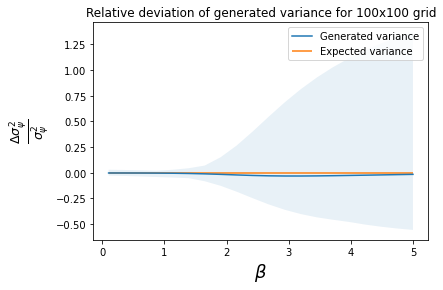

In [206]:
plt.hlines(0,betas[0],betas[-1],label='Expected variance',color='C1')
plt.plot(betas,(variances.mean(axis=1)-1),label='Generated variance',color='C0')
plt.fill_between(betas,(variances.min(axis=1)-1),(variances.max(axis=1)-1),alpha=0.1)
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$\frac{\Delta \sigma^2_{\psi}}{\sigma^2_{\psi}}$',fontsize=FS)

plt.title('Relative deviation of generated variance for 100x100 grid')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

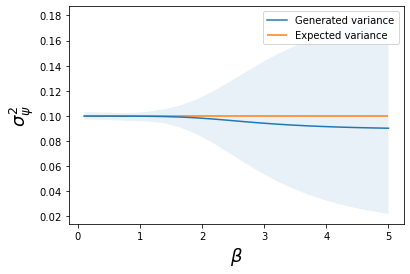

In [191]:
plt.hlines(0.1,betas[0],betas[-1],label='Expected variance',color='C1')
plt.plot(betas,variances.mean(axis=1),label='Generated variance',color='C0')
plt.fill_between(betas,variances.min(axis=1),variances.max(axis=1),alpha=0.1)
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$\sigma^2_{\psi}$',fontsize=FS)

plt.legend()
plt.show

In [167]:
PS=np.power(nonsingular_k_grid,-5)
PS[0,0]=0

In [169]:
PS.max()

32768.0

In [174]:
nonsingular_k_grid.min()

0.125

In [173]:
nonsingular_k_grid.max()

8.838834764831844

In [171]:
k_vector

array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
        1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,
        2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,  2.875,
        3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,  3.75 ,  3.875,
        4.   ,  4.125,  4.25 ,  4.375,  4.5  ,  4.625,  4.75 ,  4.875,
        5.   ,  5.125,  5.25 ,  5.375,  5.5  ,  5.625,  5.75 ,  5.875,
        6.   ,  6.125, -6.25 , -6.125, -6.   , -5.875, -5.75 , -5.625,
       -5.5  , -5.375, -5.25 , -5.125, -5.   , -4.875, -4.75 , -4.625,
       -4.5  , -4.375, -4.25 , -4.125, -4.   , -3.875, -3.75 , -3.625,
       -3.5  , -3.375, -3.25 , -3.125, -3.   , -2.875, -2.75 , -2.625,
       -2.5  , -2.375, -2.25 , -2.125, -2.   , -1.875, -1.75 , -1.625,
       -1.5  , -1.375, -1.25 , -1.125, -1.   , -0.875, -0.75 , -0.625,
       -0.5  , -0.375, -0.25 , -0.125])

In [177]:
np.fft.fftfreq(100,0.08)

array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
        1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,
        2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,  2.875,
        3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,  3.75 ,  3.875,
        4.   ,  4.125,  4.25 ,  4.375,  4.5  ,  4.625,  4.75 ,  4.875,
        5.   ,  5.125,  5.25 ,  5.375,  5.5  ,  5.625,  5.75 ,  5.875,
        6.   ,  6.125, -6.25 , -6.125, -6.   , -5.875, -5.75 , -5.625,
       -5.5  , -5.375, -5.25 , -5.125, -5.   , -4.875, -4.75 , -4.625,
       -4.5  , -4.375, -4.25 , -4.125, -4.   , -3.875, -3.75 , -3.625,
       -3.5  , -3.375, -3.25 , -3.125, -3.   , -2.875, -2.75 , -2.625,
       -2.5  , -2.375, -2.25 , -2.125, -2.   , -1.875, -1.75 , -1.625,
       -1.5  , -1.375, -1.25 , -1.125, -1.   , -0.875, -0.75 , -0.625,
       -0.5  , -0.375, -0.25 , -0.125])

In [181]:
(100/2-1)*0.125

6.125

In [183]:
def Box_Muller_Fourier_phase_grid(npix,seed,beta):
  """
  Parameters
  ----------
  npix: int
        Number of pixels along side of the image
  seed: int
        seed for random cos,sin generation

  Returns
  -------
  Fourier phase grid: (npix,npix) complex
        grid of Fourier phases obtained using Box-Muller transform Polar form (lookup wiki)
  """

  np.random.seed(seed+1)
  
  Psum=Psum_calculator(100,100,8,8,-beta)

  Fourier_phase_grid=np.zeros((npix,npix),dtype='cfloat')

  #Generate cosine,sine combinations fro Box-Muller phases
  for y in range(npix):
    for x in range(npix):
      s = 1.1
      while s>1. :
        u = np.random.uniform (-1.,1.)
        v = np.random.uniform (-1.,1.)
        s=u**2.+v**2.

      s=u**2.+v**2.
      factor=np.sqrt(-2.*np.log(s)/s)

      sigma=np.sqrt(powspec(k_grid[y][x],0.1,npix**2,Psum,-beta))
      z0=u*factor*sigma
      z1=v*factor*sigma
    
      if x==0 and y==0:
            Fourier_phase_grid[y][x]=0
      elif ([y,x]==[npix//2,0]) or ([y,x]==[0,npix//2]) or ([y,x]==[npix//2,npix//2]):
            Fourier_phase_grid[y][x]=z0
      else:
            Fourier_phase_grid[y][x]=z0+z1*(0+1j)
            
      y2=-y
      x2=-x
        
      Fourier_phase_grid[y2][x2]=Fourier_phase_grid[y][x].conjugate()

    if y>npix/2.:
        break
        
        
  return Fourier_phase_grid

In [184]:
betas=np.linspace(0.1,5,20)
variances=np.zeros((20,100))

for i,beta in tqdm(enumerate(betas)):
    for j in range(100):
        Fourier_phase_grid=Box_Muller_Fourier_phase_grid(100,j,beta)
        variances[i,j]=(np.fft.ifftshift(np.fft.ifft2(Fourier_phase_grid)).real).var()

20it [01:36,  4.85s/it]


In [ ]:
plt.hlines(0.1,betas[0],betas[-1],label='Expected variance',color='C1')
plt.plot(betas,variances.mean(axis=1),label='Generated variance',color='C0')
plt.fill_between(betas,variances.min(axis=1),variances.max(axis=1),alpha=0.1)
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$\sigma^2_{\psi}$',fontsize=FS)

plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

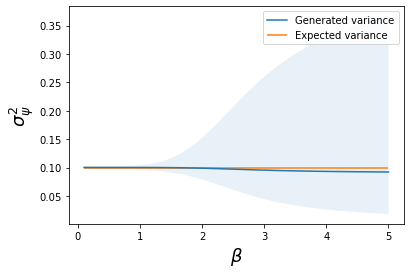

In [185]:
plt.hlines(0.1,betas[0],betas[-1],label='Expected variance',color='C1')
plt.plot(betas,variances.mean(axis=1),label='Generated variance',color='C0')
plt.fill_between(betas,variances.min(axis=1),variances.max(axis=1),alpha=0.1)
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$\sigma^2_{\psi}$',fontsize=FS)

plt.legend()
plt.show

In [54]:
nx

100

In [11]:
import GRF_perturbations.Modules.grf_functions as grf

In [51]:
logvar=-1
slope=-2


In [52]:
var_dpsi = np.power(10.,logvar)    # variance
pow_dpsi = slope                  # power-law exponent
Lx_dpsi  = npix*pix_scl                  # field of view (in arc-sec)
Ly_dpsi  = npix*pix_scl                # field of view (in arc-sec)
nx_dpsi  = npix                  # number of pixels
nx_dpsi  = npix                  # number of pixels

In [53]:
L_dpsi = Lx_dpsi
n_dpsi = nx_dpsi

nx = n_dpsi
ny = n_dpsi
Lx = L_dpsi
Ly = L_dpsi

In [16]:
resolution = float(Lx)/float(nx)
X = np.linspace(-Lx/2.0,Lx/2.0,nx)
Y = np.linspace(-Ly/2.0,Ly/2.0,ny)
x,y = np.meshgrid(X,Y,sparse='True')

grpar      = np.asarray([nx,ny,Lx,Ly,var_dpsi,pow_dpsi])
gauss_rand = grf.gauss_rand_2d(grpar)

In [17]:
betas=np.linspace(0.1,5,20)
variances=np.zeros((20,100))

for i,beta in tqdm(enumerate(betas)):
    grpar      = np.asarray([nx,ny,Lx,Ly,var_dpsi,beta])
    for j in range(100):
        np.random.seed(j+1)
        variances[i,j]=grf.gauss_rand_2d(grpar).var()

20it [01:26,  4.34s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

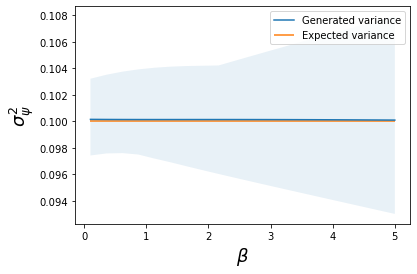

In [20]:
plt.hlines(var_dpsi,betas[0],betas[-1],label='Expected variance',color='C1')
plt.plot(betas,variances.mean(axis=1),label='Generated variance',color='C0')
plt.fill_between(betas,variances.min(axis=1),variances.max(axis=1),alpha=0.1)
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$\sigma^2_{\psi}$',fontsize=FS)

plt.legend()
plt.show

In [6]:
expected_variances=np.zeros(20)
for i,beta in tqdm(enumerate(betas)):
    expected_variances[i]=Power_Spectrum([-4,beta],nonsingular_k_grid).sum()/(pix_scl*npix)**2

20it [00:00, 1486.76it/s]


In [7]:
variances

array([[9.97034078e-09, 9.98124723e-09, 9.92980555e-09, ...,
        1.00669464e-08, 1.02074062e-08, 1.00849608e-08],
       [1.00070472e-08, 1.00011467e-08, 9.90617981e-09, ...,
        1.00966263e-08, 1.02191638e-08, 1.00668609e-08],
       [1.00647574e-08, 1.00313738e-08, 9.86544692e-09, ...,
        1.01554990e-08, 1.02182351e-08, 1.00388260e-08],
       ...,
       [9.16111407e-09, 1.85255367e-08, 8.05902865e-09, ...,
        1.31140258e-08, 9.63788941e-09, 6.41486745e-09],
       [8.86802027e-09, 1.88621363e-08, 8.09882274e-09, ...,
        1.29736553e-08, 9.79330725e-09, 6.38065305e-09],
       [8.59524455e-09, 1.91590819e-08, 8.14443526e-09, ...,
        1.28358983e-08, 9.94224937e-09, 6.35845157e-09]])

<function matplotlib.pyplot.show(close=None, block=None)>

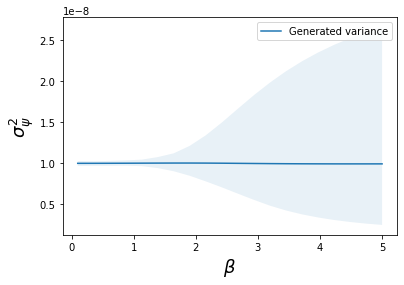

In [9]:
#plt.hlines(expectred_var,betas[0],betas[-1],label='Expected variance',color='C1')
#plt.plot(betas,expected_variances,label='Expected variance',color='C1')
plt.plot(betas,variances.mean(axis=1),label='Generated variance',color='C0')
plt.fill_between(betas,variances.min(axis=1),variances.max(axis=1),alpha=0.1)
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$\sigma^2_{\psi}$',fontsize=FS)

plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

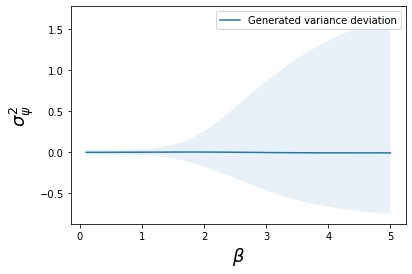

In [27]:
plt.plot(betas,(variances.mean(axis=1)-expected_variances)/expected_variances,label='Generated variance deviation',color='C0')
plt.fill_between(betas,(variances.min(axis=1)-expected_variances)/expected_variances,(variances.max(axis=1)-expected_variances)/expected_variances,alpha=0.1)
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$\sigma^2_{\psi}$',fontsize=FS)

plt.legend()
plt.show

In [22]:
np.random.seed(42)
ny=npix
nx=npix

j= 0 + 1j # Defining the complex number
plane = np.zeros ([nx, ny], dtype='cfloat') 

lxaxis = np.fft.fftfreq (npix, pix_scl)
lyaxis = np.fft.fftfreq (npix, pix_scl)

for y in range(npix):
        for x in range(npix):
            # The coordinates centered at x = n/2, y = n/2
            i1 = x - npix/2
            j1 = y - npix/2 

            #The coordinates in the Fourier plane
            lx = lxaxis [x]
            ly = lyaxis [y]
            # The magnitude of the l-vector
            l = np.sqrt (lx**2. + ly**2.) 

            # Polar Box-Muller transform
            #sigma = math.sqrt(powspec(l, var, nx*ny, Psum, power))
            s = 1.1
            while s > 1. :
                u = np.random.uniform (-1.,1.) 
                v = np.random.uniform (-1.,1.)
                s = u**2. + v**2.
            fac = math.sqrt(-2.*math.log(s)/s)
            z1 = u*fac
            z2 = v*fac

            # Filling in the grid
            if x==0 and y==0: # average of the field
                plane[y][x] = 0.0

            # three points that need to be real valued to get a real image after FFT:
            elif x== 0 and y==ny/2:
                plane[y][x] = z1
            elif x==nx/2 and y==0:
                plane[y][x] = z1
            elif x==nx/2 and y==ny/2:
                plane[y][x] = z1
            else :
                plane[y][x] = z1+j*z2

            # Creating symmetry f(k) = f*(-k)
            y2 = int( -(j1 + ny/2) )
            x2 = int( -(i1 + nx/2) )
        
            plane[y2][x2] = plane[y][x].conjugate()

        if y>nx/2.:
            break

In [23]:
plane

array([[ 0.        -0.j        , -1.1429703 -0.05820872j,
         0.15372511+0.88385744j, ...,  0.38531738+0.17318093j,
         0.15372511-0.88385744j, -1.1429703 +0.05820872j],
       [ 0.56078453+0.35778736j,  1.05380205+1.08305124j,
        -0.93782504-1.37766937j, ..., -0.46917565+1.17944012j,
         1.35387237-1.71313453j,  1.23781631-0.11453985j],
       [-0.59937502-1.59442766j,  0.04698059+0.0052437j ,
         0.62284993-0.45006547j, ..., -0.5100164 +1.03753994j,
        -0.97876372-0.26987494j,  0.37730049-0.44429326j],
       ...,
       [-0.92216532-0.75698862j,  0.02975614-0.02831838j,
         0.6815007 +0.03955515j, ..., -1.2446547 +0.7737892j ,
         1.87679581-0.4134349j ,  1.35563786-0.86960592j],
       [-0.59937502+1.59442766j,  0.37730049+0.44429326j,
        -0.97876372+0.26987494j, ..., -0.14237949+1.06762043j,
         0.62284993+0.45006547j,  0.04698059-0.0052437j ],
       [ 0.56078453-0.35778736j,  1.23781631+0.11453985j,
         1.35387237+1.71313453

In [19]:
Box_Muller_Fourier_phase_grid(100,41)

array([[ 0.        -0.j        ,  1.52302986+0.64768854j,
        -0.23413696-0.23415337j, ...,  0.76743473-1.57921282j,
        -0.23413696+0.23415337j,  1.52302986-0.64768854j],
       [ 0.56078453+0.35778736j,  1.05380205+1.08305124j,
        -0.93782504-1.37766937j, ..., -0.46917565+1.17944012j,
         1.35387237-1.71313453j,  1.23781631-0.11453985j],
       [-0.59937502-1.59442766j,  0.04698059+0.0052437j ,
         0.62284993-0.45006547j, ..., -0.5100164 +1.03753994j,
        -0.97876372-0.26987494j,  0.37730049-0.44429326j],
       ...,
       [-0.92216532-0.75698862j,  0.02975614-0.02831838j,
         0.6815007 +0.03955515j, ..., -1.2446547 +0.7737892j ,
         1.87679581-0.4134349j ,  1.35563786-0.86960592j],
       [-0.59937502+1.59442766j,  0.37730049+0.44429326j,
        -0.97876372+0.26987494j, ..., -0.14237949+1.06762043j,
         0.62284993+0.45006547j,  0.04698059-0.0052437j ],
       [ 0.56078453-0.35778736j,  1.23781631+0.11453985j,
         1.35387237+1.71313453

In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

In [2]:
from GRF_perturbations.Modules.GRF_generation import *

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
k_grid,nonsingular_k_grid=get_k_grid(100,0.08)

In [6]:
PS=nonsingular_Power_spectrum([-3,3],nonsingular_k_grid)

In [7]:
PS.sum()

DeviceArray(4.56828329, dtype=float64)

In [8]:
Fourier_phase=get_Fourier_phase(100,4)

In [9]:
GRF=get_jaxified_GRF([-3,3],nonsingular_k_grid,Fourier_phase)

In [10]:
GRF.var()

DeviceArray(4.56727773, dtype=float64)

In [11]:
import jax

In [12]:
get_GRF_pure=jax.jit(lambda GRF_params: get_jaxified_GRF(GRF_params,nonsingular_k_grid,Fourier_phase))

In [13]:
Pow_spec_pure=jax.jit(lambda GRF_params: nonsingular_Power_spectrum(GRF_params,nonsingular_k_grid))

In [14]:
jax.grad(lambda GRF_params: jnp.sum(Pow_spec_pure(GRF_params)))([-3.,3.])

[DeviceArray(10.518861, dtype=float64),
 DeviceArray(6.64705527, dtype=float64, weak_type=True)]

In [15]:
jnp.var(get_GRF_pure([-3.,3.]))

DeviceArray(4.56727773, dtype=float64)

In [16]:
jax.grad(lambda GRF_params: jnp.var(get_GRF_pure(GRF_params)))([-3.,3.])

[DeviceArray(10.51654561, dtype=float64),
 DeviceArray(6.6470658, dtype=float64, weak_type=True)]

In [22]:
PS.sum()

DeviceArray(4.56828329, dtype=float64)

In [18]:
jnp.var(get_GRF_pure(GRF_params))

DeviceArray(4.56727773, dtype=float64)

In [17]:
GRF_params=[-3,3]

In [16]:
Pow_spec_pure(GRF_params)

DeviceArray([[0.        , 0.512     , 0.064     , ..., 0.01896296,
              0.064     , 0.512     ],
             [0.512     , 0.18101934, 0.04579467, ..., 0.01619086,
              0.04579467, 0.18101934],
             [0.064     , 0.04579467, 0.02262742, ..., 0.01092333,
              0.02262742, 0.04579467],
             ...,
             [0.01896296, 0.01619086, 0.01092333, ..., 0.00670442,
              0.01092333, 0.01619086],
             [0.064     , 0.04579467, 0.02262742, ..., 0.01092333,
              0.02262742, 0.04579467],
             [0.512     , 0.18101934, 0.04579467, ..., 0.01619086,
              0.04579467, 0.18101934]], dtype=float64)

In [18]:
np.ones((10,10),dtype='float64')

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [18]:
Pow_spec_pure(GRF_params)

DeviceArray([[0.001     , 0.512     , 0.064     , ..., 0.01896296,
              0.064     , 0.512     ],
             [0.512     , 0.18101934, 0.04579467, ..., 0.01619086,
              0.04579467, 0.18101934],
             [0.064     , 0.04579467, 0.02262742, ..., 0.01092333,
              0.02262742, 0.04579467],
             ...,
             [0.01896296, 0.01619086, 0.01092333, ..., 0.00670442,
              0.01092333, 0.01619086],
             [0.064     , 0.04579467, 0.02262742, ..., 0.01092333,
              0.02262742, 0.04579467],
             [0.512     , 0.18101934, 0.04579467, ..., 0.01619086,
              0.04579467, 0.18101934]], dtype=float64)

In [19]:
k_grid

array([[0.        , 0.125     , 0.25      , ..., 0.375     , 0.25      ,
        0.125     ],
       [0.125     , 0.1767767 , 0.2795085 , ..., 0.39528471, 0.2795085 ,
        0.1767767 ],
       [0.25      , 0.2795085 , 0.35355339, ..., 0.45069391, 0.35355339,
        0.2795085 ],
       ...,
       [0.375     , 0.39528471, 0.45069391, ..., 0.53033009, 0.45069391,
        0.39528471],
       [0.25      , 0.2795085 , 0.35355339, ..., 0.45069391, 0.35355339,
        0.2795085 ],
       [0.125     , 0.1767767 , 0.2795085 , ..., 0.39528471, 0.2795085 ,
        0.1767767 ]])

In [20]:
nonsingular_k_grid

array([[1.        , 0.125     , 0.25      , ..., 0.375     , 0.25      ,
        0.125     ],
       [0.125     , 0.1767767 , 0.2795085 , ..., 0.39528471, 0.2795085 ,
        0.1767767 ],
       [0.25      , 0.2795085 , 0.35355339, ..., 0.45069391, 0.35355339,
        0.2795085 ],
       ...,
       [0.375     , 0.39528471, 0.45069391, ..., 0.53033009, 0.45069391,
        0.39528471],
       [0.25      , 0.2795085 , 0.35355339, ..., 0.45069391, 0.35355339,
        0.2795085 ],
       [0.125     , 0.1767767 , 0.2795085 , ..., 0.39528471, 0.2795085 ,
        0.1767767 ]])

In [23]:
from GRF_perturbations.Modules.Inference import Inference

In [ ]:
Inf_class=Inference()